<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Surrogate_Model_for_Cavity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 21/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0025 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 22/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 23/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0024 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 24/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 25/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 26/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 27/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 28/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.00

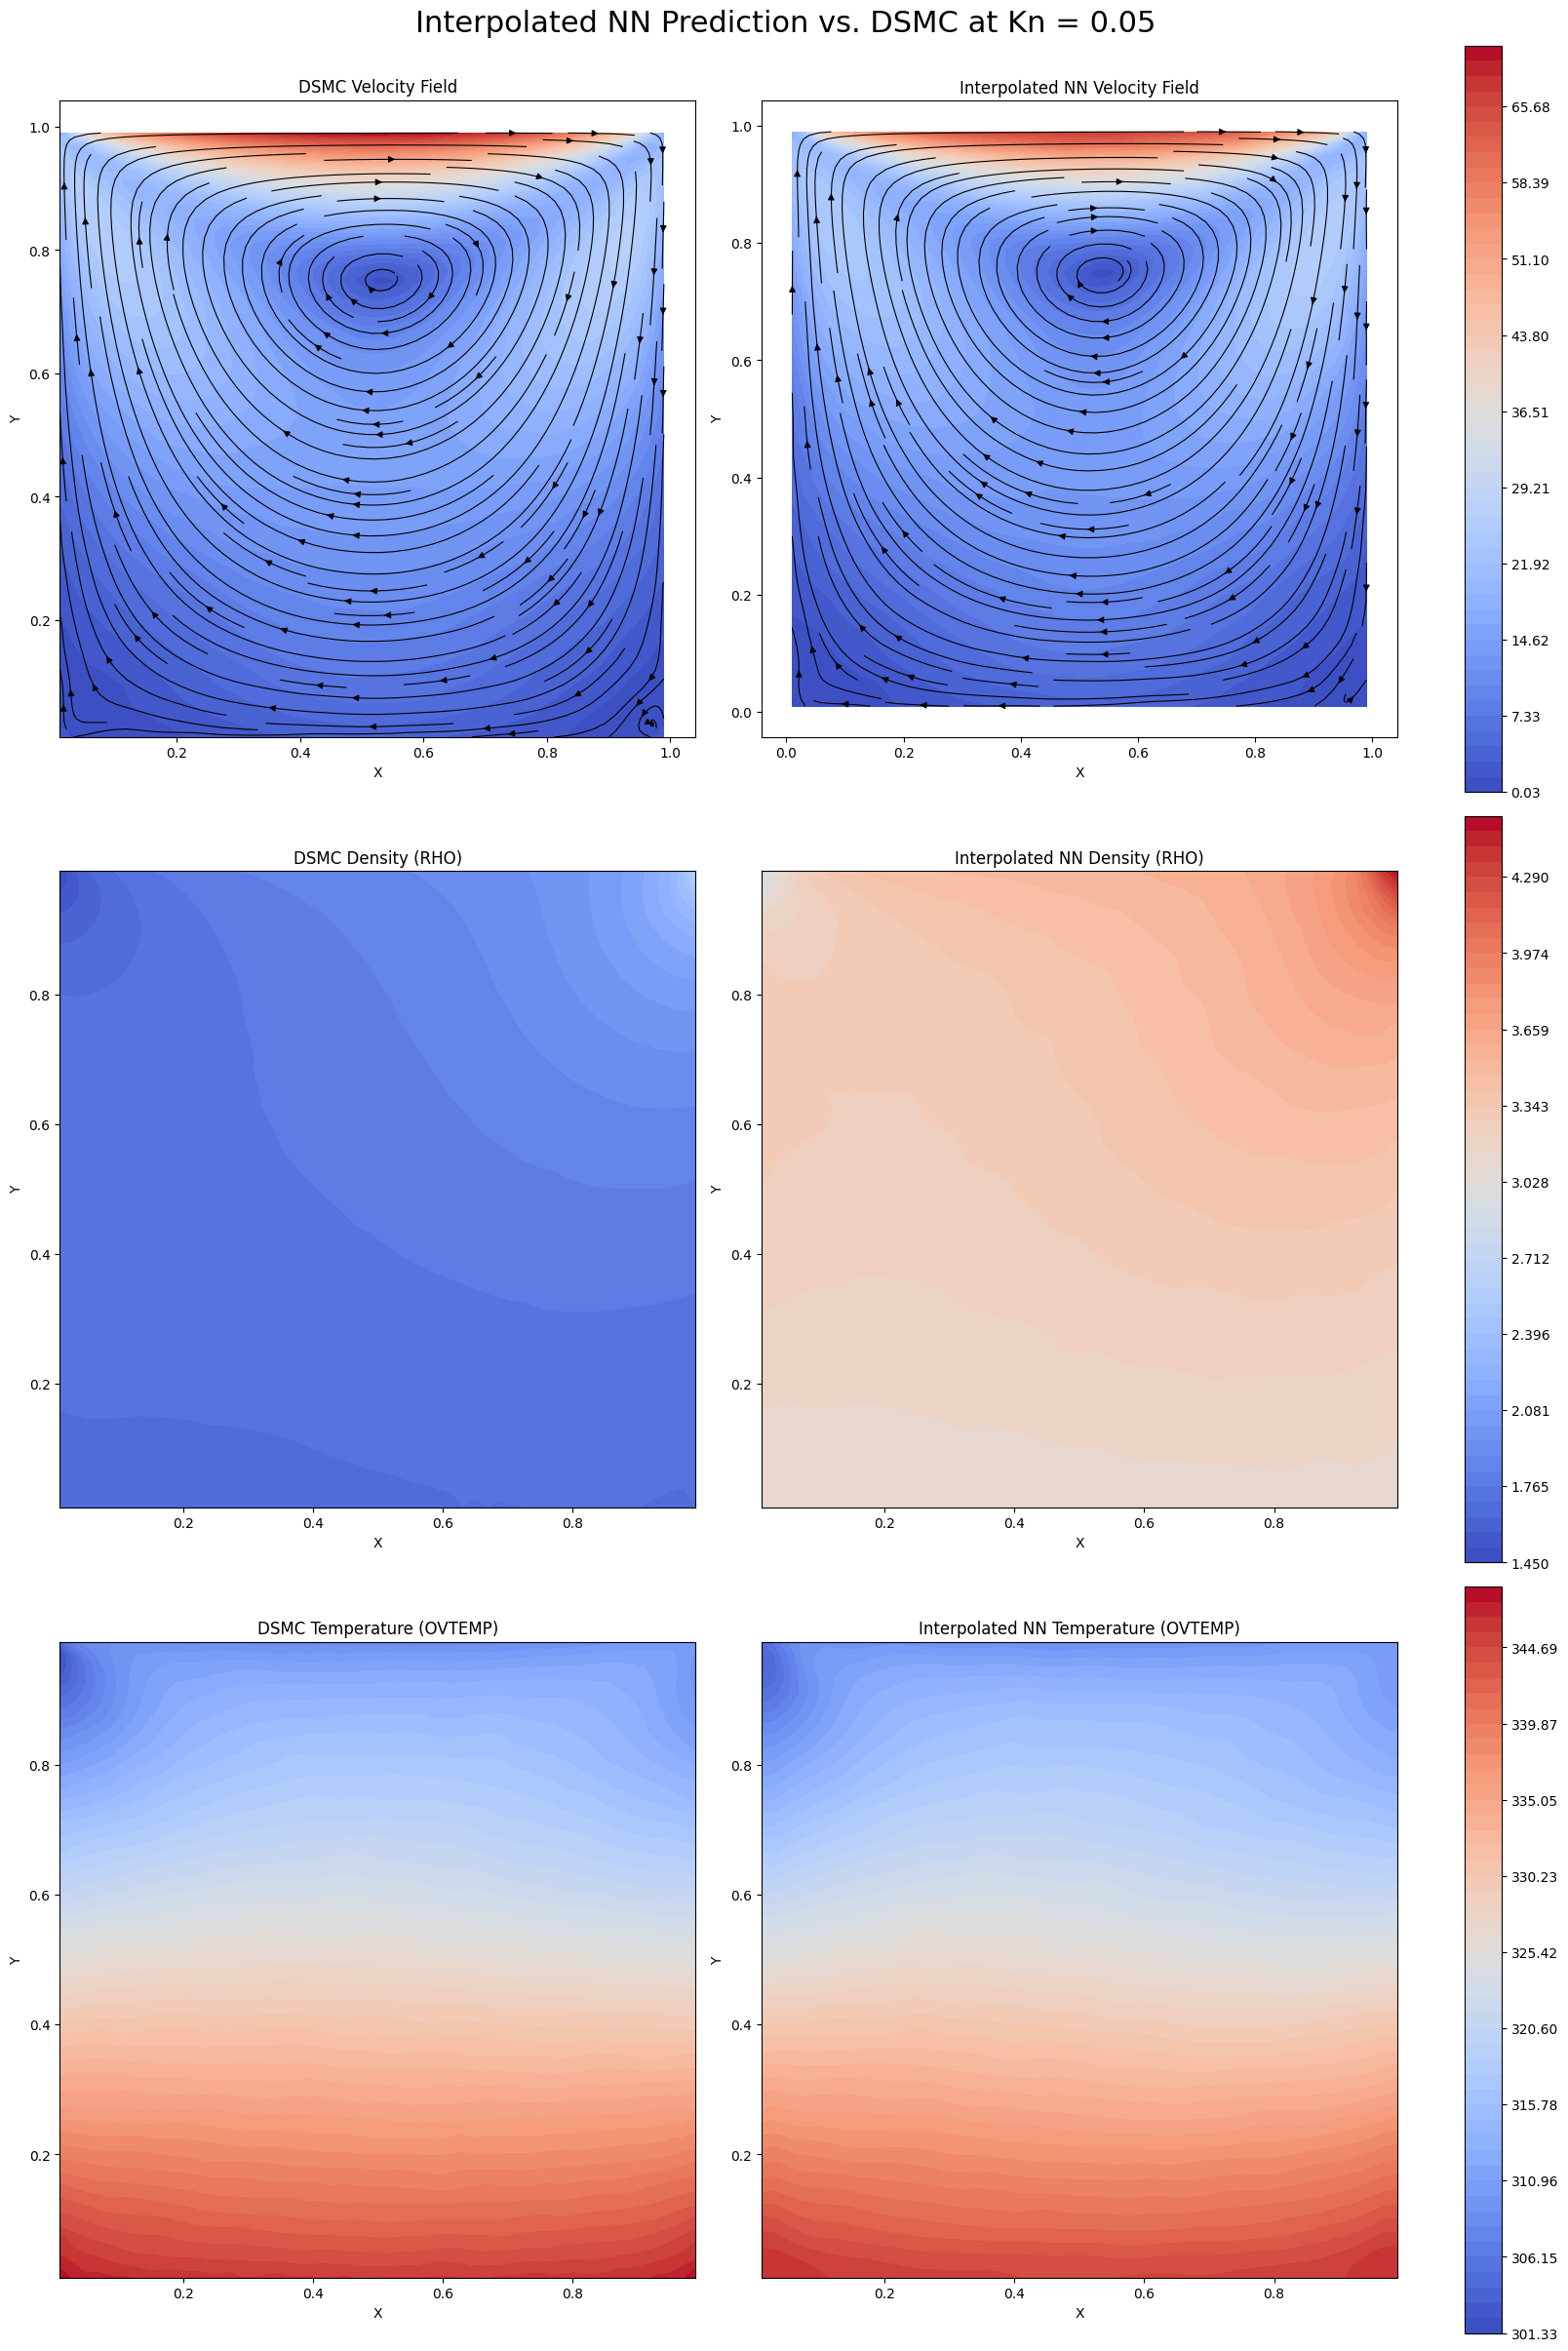

In [ ]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف مدل و داده‌ها ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
test_kn_value = 0.05
DATA_DIR = './'

# --- گام ۳: آموزش خانواده‌ای از مدل‌های متخصص (با تقسیم داده صحیح) ---
trained_models = {}
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])

for kn_val in train_kn_values:
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")

    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath is None:
        print(f"File not found for Kn={kn_val}, skipping.")
        continue

    df, metadata = parse_tecplot_block_ascii(filepath)
    if df.empty: continue

    input_features = ['X', 'Y']
    output_features = [v for v in metadata['variables'] if v not in ['X', 'Y']]
    X_data = df[input_features].values
    y_data = df[output_features].values

    # CHANGED: Manually split the data for this Kn into train and validation sets
    # This ensures the data is shuffled and validation is meaningful.
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(
        X_data, y_data, test_size=0.15, random_state=42
    )

    # Scalers are fit ONLY on the training part of the loop's data
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_loop_scaled = scaler_X.fit_transform(X_train_loop)
    y_train_loop_scaled = scaler_y.fit_transform(y_train_loop)

    # Transform the validation part using the same scalers
    X_val_loop_scaled = scaler_X.transform(X_val_loop)
    y_val_loop_scaled = scaler_y.transform(y_val_loop)

    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))

    print("Starting proper training...")
    model.fit(
        X_train_loop_scaled, y_train_loop_scaled,
        epochs=1000,
        batch_size=256,
        verbose=1,
        validation_data=(X_val_loop_scaled, y_val_loop_scaled), # Use the manually created validation set
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1)
        ]
    )

    trained_models[kn_val] = (model, scaler_X, scaler_y, metadata)
    print(f"Finished training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")

# --- گام ۴ و ۵ (بدون تغییر) ---
# ... (کد مربوط به درون‌یابی و مصورسازی را در اینجا کپی کنید) ...
# It is assumed the user has the last correct version of these blocks.
# The following is the full code for Step 4 and 5 for completeness.

# --- گام ۴: درون‌یابی و پیش‌بینی برای داده تست ---
print(f"\n{'='*50}\nPerforming interpolation for test case Kn = {test_kn_value}\n{'='*50}")

test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")

test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']

kn_upper = min([kn for kn in train_kn_values if kn > test_kn_value])
kn_lower = max([kn for kn in train_kn_values if kn < test_kn_value])
print(f"Found neighbors for interpolation: Kn_lower={kn_lower}, Kn_upper={kn_upper}")

model_lower, scaler_X_lower, scaler_y_lower, _ = trained_models[kn_lower]
model_upper, scaler_X_upper, scaler_y_upper, _ = trained_models[kn_upper]

X_test_lower_scaled = scaler_X_lower.transform(X_test_coords)
y_pred_lower_scaled = model_lower.predict(X_test_lower_scaled)
y_pred_lower = scaler_y_lower.inverse_transform(y_pred_lower_scaled)

X_test_upper_scaled = scaler_X_upper.transform(X_test_coords)
y_pred_upper_scaled = model_upper.predict(X_test_upper_scaled)
y_pred_upper = scaler_y_upper.inverse_transform(y_pred_upper_scaled)

log_kn_test, log_kn_lower, log_kn_upper = np.log10(test_kn_value), np.log10(kn_lower), np.log10(kn_upper)
weight = (log_kn_test - log_kn_lower) / (log_kn_upper - log_kn_lower)
print(f"Interpolation weight (w) = {weight:.4f}")

y_pred_final = (1 - weight) * y_pred_lower + weight * y_pred_upper
y_pred_df = pd.DataFrame(y_pred_final, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی جامع نتایج ---
def plot_full_field_comparison(ground_truth_df, df_pred, I, J, kn_value):
    fig, axes = plt.subplots(3, 2, figsize=(16, 24), constrained_layout=True)
    fig.suptitle(f'Interpolated NN Prediction vs. DSMC at Kn = {kn_value}', fontsize=22)
    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    # Velocity
    Vmag_true, U_true_grid, V_true_grid = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I), ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    Vmag_pred, U_pred_grid, V_pred_grid = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I), df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    vmin, vmax = np.min([Vmag_true, Vmag_pred]), np.max([Vmag_true, Vmag_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[0, 0].set_title('DSMC Velocity Field'); axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); axes[0, 0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)
    axes[0, 1].set_title('Interpolated NN Velocity Field'); cf_v = axes[0, 1].contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); axes[0, 1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8); fig.colorbar(cf_v, ax=axes[0, :].ravel().tolist())

    # Density
    Rho_true, Rho_pred = ground_truth_df['RHO'].values.reshape(J, I), df_pred['RHO'].values.reshape(J, I)
    vmin, vmax = np.min([Rho_true, Rho_pred]), np.max([Rho_true, Rho_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[1, 0].set_title('DSMC Density (RHO)'); axes[1, 0].contourf(X_grid, Y_grid, Rho_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1, 1].set_title('Interpolated NN Density (RHO)'); cf_r = axes[1, 1].contourf(X_grid, Y_grid, Rho_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); fig.colorbar(cf_r, ax=axes[1, :].ravel().tolist())

    # Temperature
    Temp_true, Temp_pred = ground_truth_df['OVTEMP'].values.reshape(J, I), df_pred['OVTEMP'].values.reshape(J, I)
    vmin, vmax = np.min([Temp_true, Temp_pred]), np.max([Temp_true, Temp_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[2, 0].set_title('DSMC Temperature (OVTEMP)'); axes[2, 0].contourf(X_grid, Y_grid, Temp_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[2, 1].set_title('Interpolated NN Temperature (OVTEMP)'); cf_t = axes[2, 1].contourf(X_grid, Y_grid, Temp_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); fig.colorbar(cf_t, ax=axes[2, :].ravel().tolist())

    for ax in axes.flat: ax.set_aspect('equal', adjustable='box'); ax.set_xlabel('X'); ax.set_ylabel('Y')
    output_filename = f'interpolated_results_kn_{kn_value}.jpg'; plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار جامع در فایل '{output_filename}' ذخیره شد."); plt.show()

plot_full_field_comparison(test_df, y_pred_df, I, J, test_kn_value)


Training specialist model for Kn = 0.001
Parsing file: ./CavityKn0001.dat...
Successfully parsed 2500 points and 11 variables.
Finished training for Kn = 0.001 in 80.86 seconds.

Training specialist model for Kn = 0.01
Parsing file: ./CavityKn001.dat...
Successfully parsed 2500 points and 11 variables.
Finished training for Kn = 0.01 in 77.52 seconds.

Training specialist model for Kn = 0.1
Parsing file: ./CavityKn01.dat...
Successfully parsed 2500 points and 11 variables.
Finished training for Kn = 0.1 in 76.71 seconds.

Training specialist model for Kn = 0.5
Parsing file: ./CavityKn05.dat...
Successfully parsed 2500 points and 11 variables.
Finished training for Kn = 0.5 in 65.35 seconds.

Training specialist model for Kn = 1.0
Parsing file: ./CavityKn1.dat...
Successfully parsed 2500 points and 11 variables.
Finished training for Kn = 1.0 in 82.18 seconds.

Training specialist model for Kn = 10.0
Parsing file: ./CavityKn10.dat...
Successfully parsed 2500 points and 11 variables.
Fi

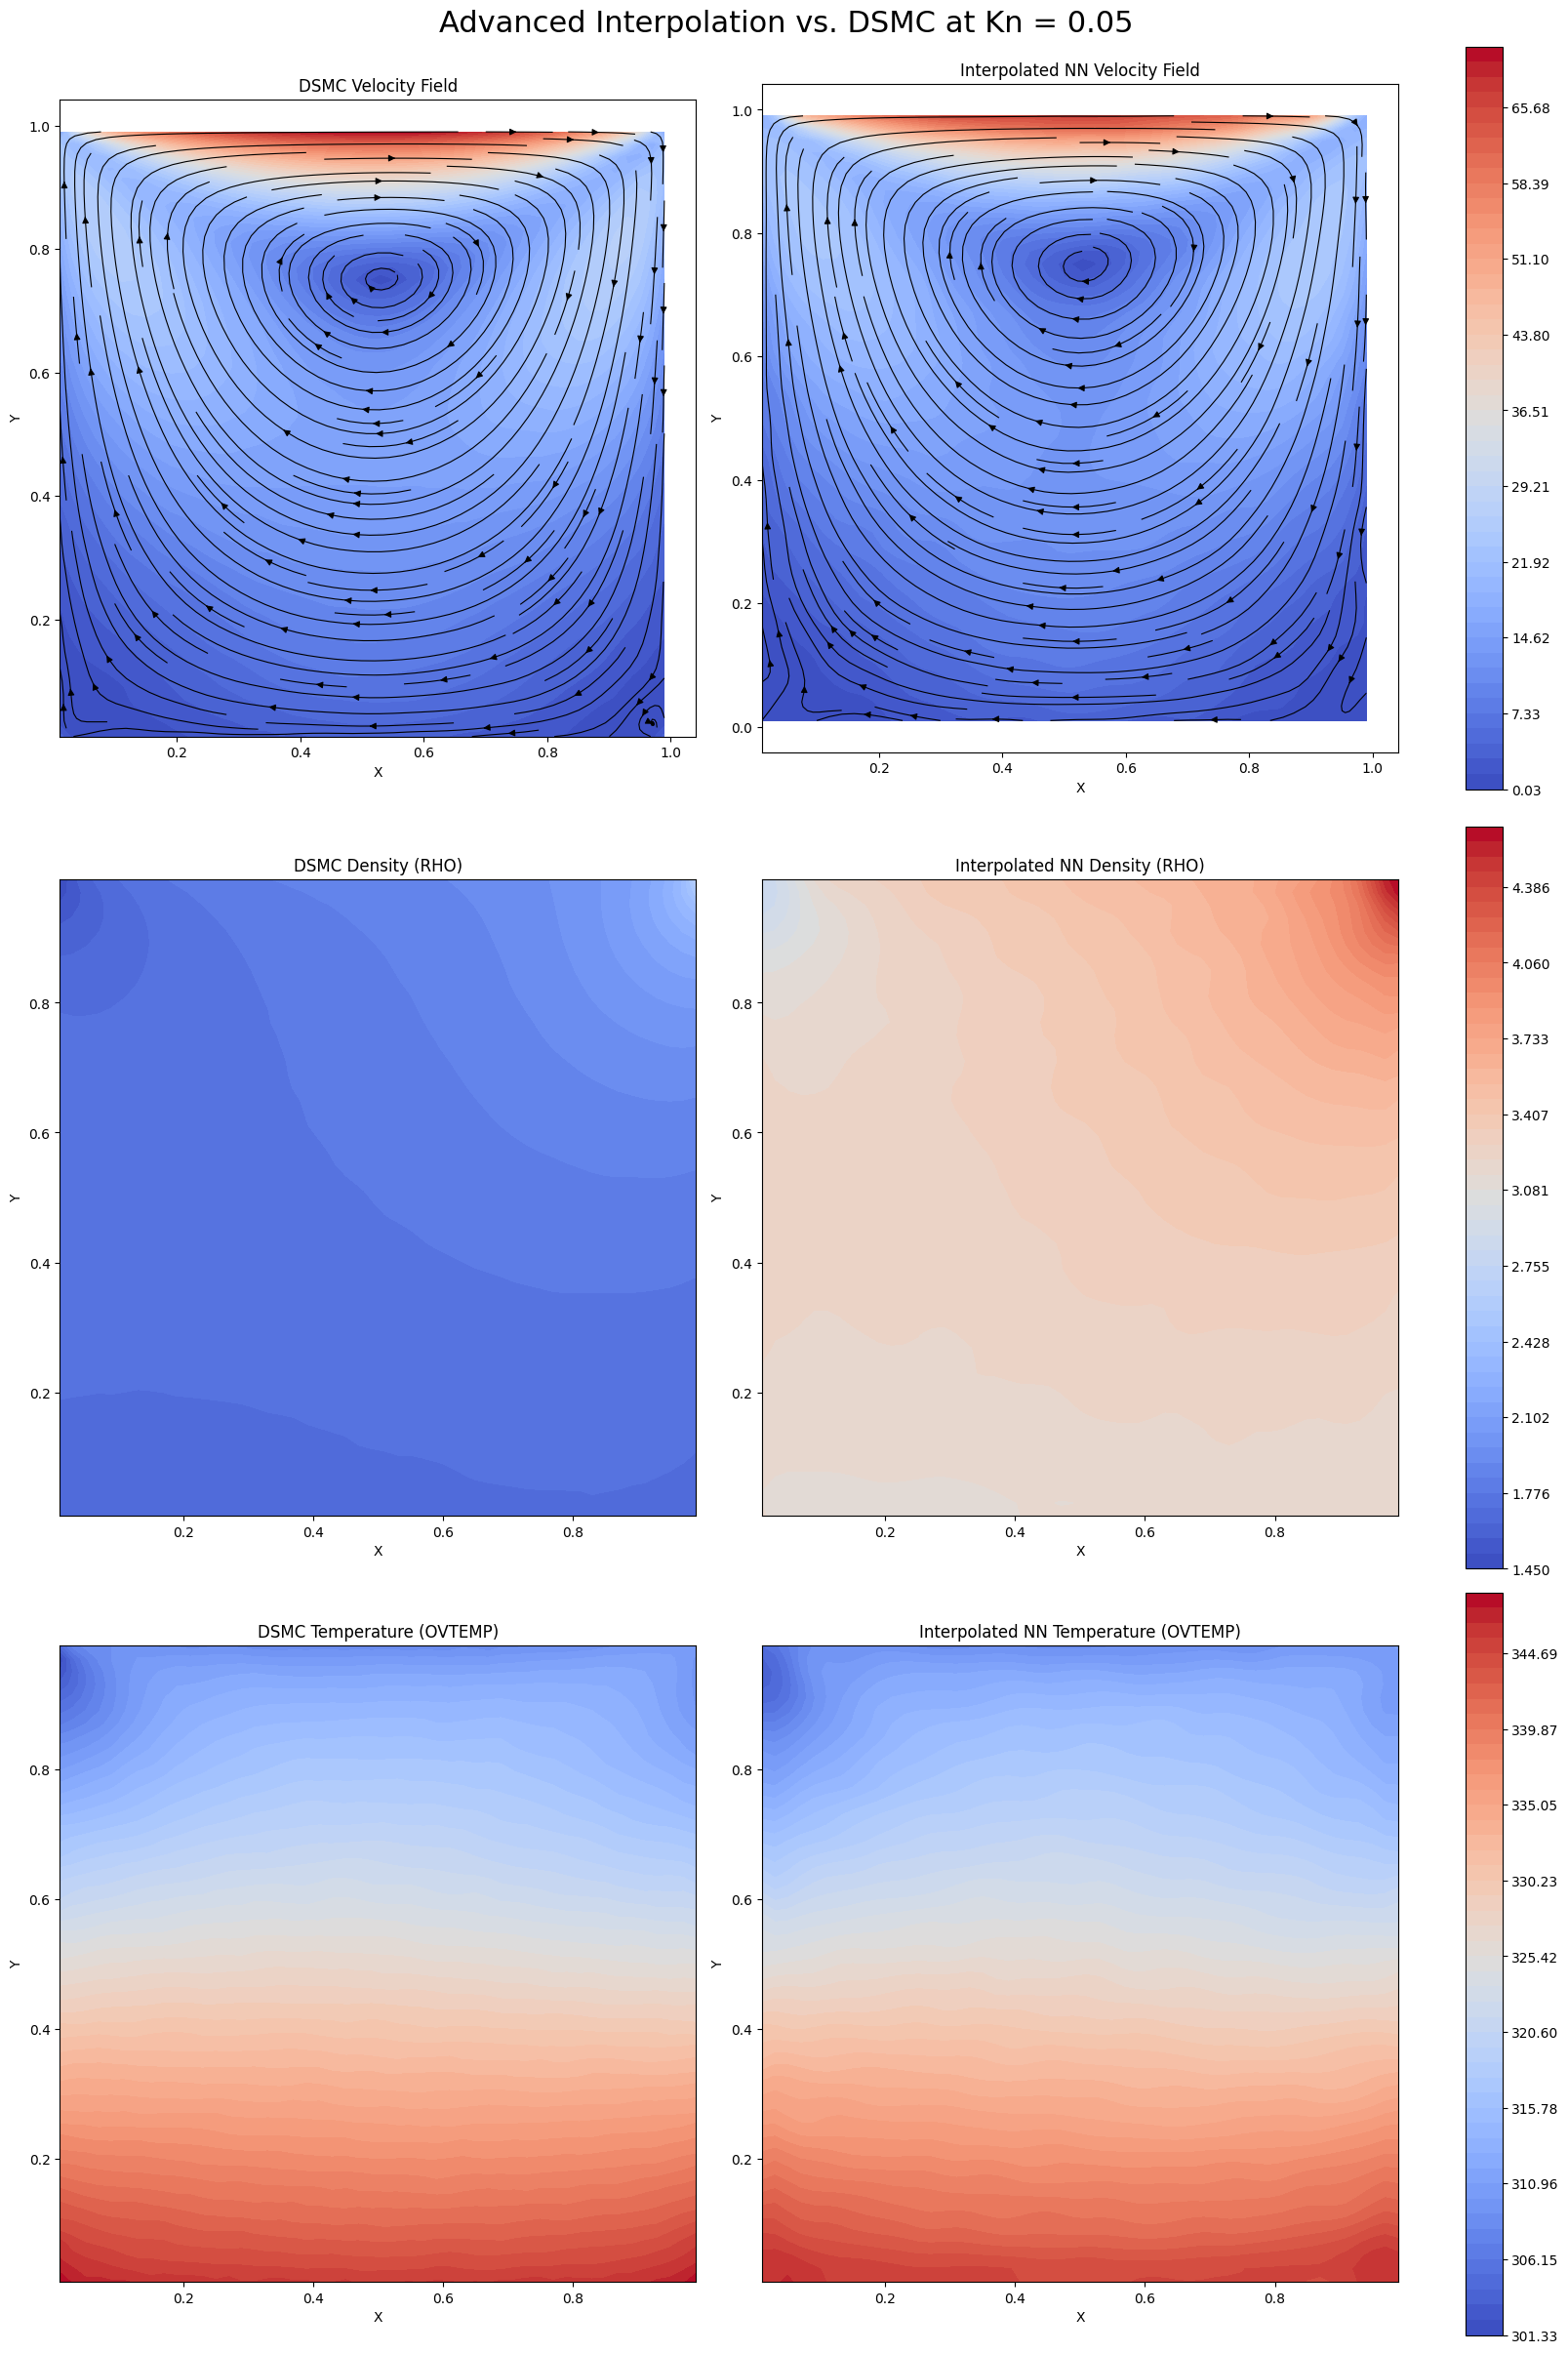

In [ ]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d
import time
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف مدل و داده‌ها ---
def create_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
test_kn_value = 0.05
DATA_DIR = './'

# --- گام ۳: آموزش خانواده مدل‌ها با داده‌های بی‌بُعد شده ---
trained_models = {}
reference_values = {}
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])

for kn_val in train_kn_values:
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")

    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath is None: print(f"File for Kn={kn_val} not found, skipping."); continue

    df, metadata = parse_tecplot_block_ascii(filepath)
    if df.empty: continue

    # --- بی‌بعدسازی ---
    U_ref = df['U'].abs().max() # سرعت دیواره
    RHO_ref = df['RHO'].mean() # چگالی متوسط
    T_ref = df['OVTEMP'].mean() # دمای متوسط
    reference_values[kn_val] = {'U': U_ref, 'RHO': RHO_ref, 'OVTEMP': T_ref}

    df_nondim = df.copy()
    # بی‌بعدسازی متغیرهای اصلی
    for v in ['U', 'V', 'W']: df_nondim[v] /= U_ref
    df_nondim['RHO'] /= RHO_ref
    df_nondim['OVTEMP'] /= T_ref

    input_features, output_features = ['X', 'Y'], [v for v in metadata['variables'] if v not in ['X', 'Y']]
    X_data, y_data = df_nondim[input_features].values, df_nondim[output_features].values

    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.15, random_state=42)
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_scaled, y_train_scaled = scaler_X.fit_transform(X_train), scaler_y.fit_transform(y_train)
    X_val_scaled, y_val_scaled = scaler_X.transform(X_val), scaler_y.transform(y_val)

    model = create_specialist_model(input_shape=(2,), output_shape=len(output_features))
    model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=512, verbose=0, validation_data=(X_val_scaled, y_val_scaled),
              callbacks=[keras.callbacks.EarlyStopping(patience=75, restore_best_weights=True), keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)])

    trained_models[kn_val] = (model, scaler_X, scaler_y)
    print(f"Finished training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")

# --- گام ۴: درون‌یابی پیشرفته برای داده تست ---
print(f"\n{'='*50}\nPerforming advanced interpolation for test case Kn = {test_kn_value}\n{'='*50}")

test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")
test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']

# پیدا کردن همسایه‌ها برای درون‌یابی (مثلاً ۴ تای نزدیک‌ترین)
sorted_kn = sorted(train_kn_values, key=lambda k: abs(np.log10(k) - np.log10(test_kn_value)))
neighbors_kn = sorted_kn[:4] # استفاده از ۴ همسایه
print(f"Found neighbors for interpolation: {neighbors_kn}")

# پیش‌بینی با تمام مدل‌های همسایه
neighbor_predictions = []
for kn in neighbors_kn:
    model, scaler_X, scaler_y = trained_models[kn]
    X_test_scaled = scaler_X.transform(X_test_coords)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred_nondim = scaler_y.inverse_transform(y_pred_scaled)
    neighbor_predictions.append(y_pred_nondim)

# انجام درون‌یابی درجه دوم برای هر نقطه و هر متغیر
log_kn_neighbors = np.log10(neighbors_kn)
log_kn_test = np.log10(test_kn_value)
y_pred_final_nondim = np.zeros_like(neighbor_predictions[0])

print("Interpolating point by point...")
for i in range(y_pred_final_nondim.shape[0]): # Loop over points
    for j in range(y_pred_final_nondim.shape[1]): # Loop over variables
        # جمع‌آوری مقادیر پیش‌بینی شده برای این نقطه و متغیر از تمام همسایه‌ها
        values = [pred[i, j] for pred in neighbor_predictions]
        # ساخت تابع درون‌یاب
        interp_func = interp1d(log_kn_neighbors, values, kind='quadratic', fill_value="extrapolate")
        # درون‌یابی
        y_pred_final_nondim[i, j] = interp_func(log_kn_test)

# --- برگرداندن به مقادیر با بُعد ---
# درون‌یابی مقادیر مرجع
ref_U = interp1d(np.log10(list(reference_values.keys())), [v['U'] for v in reference_values.values()], kind='linear')(log_kn_test)
ref_RHO = interp1d(np.log10(list(reference_values.keys())), [v['RHO'] for v in reference_values.values()], kind='linear')(log_kn_test)
ref_T = interp1d(np.log10(list(reference_values.keys())), [v['OVTEMP'] for v in reference_values.values()], kind='linear')(log_kn_test)

y_pred_df = pd.DataFrame(y_pred_final_nondim, columns=output_features)
for v in ['U', 'V', 'W']: y_pred_df[v] *= ref_U
y_pred_df['RHO'] *= ref_RHO
y_pred_df['OVTEMP'] *= ref_T
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی جامع نتایج ---
# (تابع مصورسازی بدون تغییر باقی می‌ماند و از کد قبلی استفاده می‌شود)
def plot_full_field_comparison(ground_truth_df, df_pred, I, J, kn_value):
    fig, axes = plt.subplots(3, 2, figsize=(16, 24), constrained_layout=True)
    fig.suptitle(f'Advanced Interpolation vs. DSMC at Kn = {kn_value}', fontsize=22)
    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    # Velocity
    Vmag_true, U_true_grid, V_true_grid = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I), ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    Vmag_pred, U_pred_grid, V_pred_grid = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I), df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    vmin, vmax = np.min([Vmag_true, Vmag_pred]), np.max([Vmag_true, Vmag_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[0, 0].set_title('DSMC Velocity Field'); axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); axes[0, 0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)
    axes[0, 1].set_title('Interpolated NN Velocity Field'); cf_v = axes[0, 1].contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); axes[0, 1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8); fig.colorbar(cf_v, ax=axes[0, :].ravel().tolist())

    # Density
    Rho_true, Rho_pred = ground_truth_df['RHO'].values.reshape(J, I), df_pred['RHO'].values.reshape(J, I)
    vmin, vmax = np.min([Rho_true, Rho_pred]), np.max([Rho_true, Rho_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[1, 0].set_title('DSMC Density (RHO)'); axes[1, 0].contourf(X_grid, Y_grid, Rho_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1, 1].set_title('Interpolated NN Density (RHO)'); cf_r = axes[1, 1].contourf(X_grid, Y_grid, Rho_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); fig.colorbar(cf_r, ax=axes[1, :].ravel().tolist())

    # Temperature
    Temp_true, Temp_pred = ground_truth_df['OVTEMP'].values.reshape(J, I), df_pred['OVTEMP'].values.reshape(J, I)
    vmin, vmax = np.min([Temp_true, Temp_pred]), np.max([Temp_true, Temp_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[2, 0].set_title('DSMC Temperature (OVTEMP)'); axes[2, 0].contourf(X_grid, Y_grid, Temp_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[2, 1].set_title('Interpolated NN Temperature (OVTEMP)'); cf_t = axes[2, 1].contourf(X_grid, Y_grid, Temp_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); fig.colorbar(cf_t, ax=axes[2, :].ravel().tolist())

    for ax in axes.flat: ax.set_aspect('equal', adjustable='box'); ax.set_xlabel('X'); ax.set_ylabel('Y')
    output_filename = f'advanced_interpolated_results_kn_{kn_value}.jpg'; plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار جامع در فایل '{output_filename}' ذخیره شد."); plt.show()

plot_full_field_comparison(test_df, y_pred_df, I, J, test_kn_value)

Streaming output truncated to the last 5000 lines.
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 327/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 328/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 329/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 330/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 331/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 332/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 333/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014 - val_loss: 0.0016 - learning_rate: 7.8125e-06
Epoch 334/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1

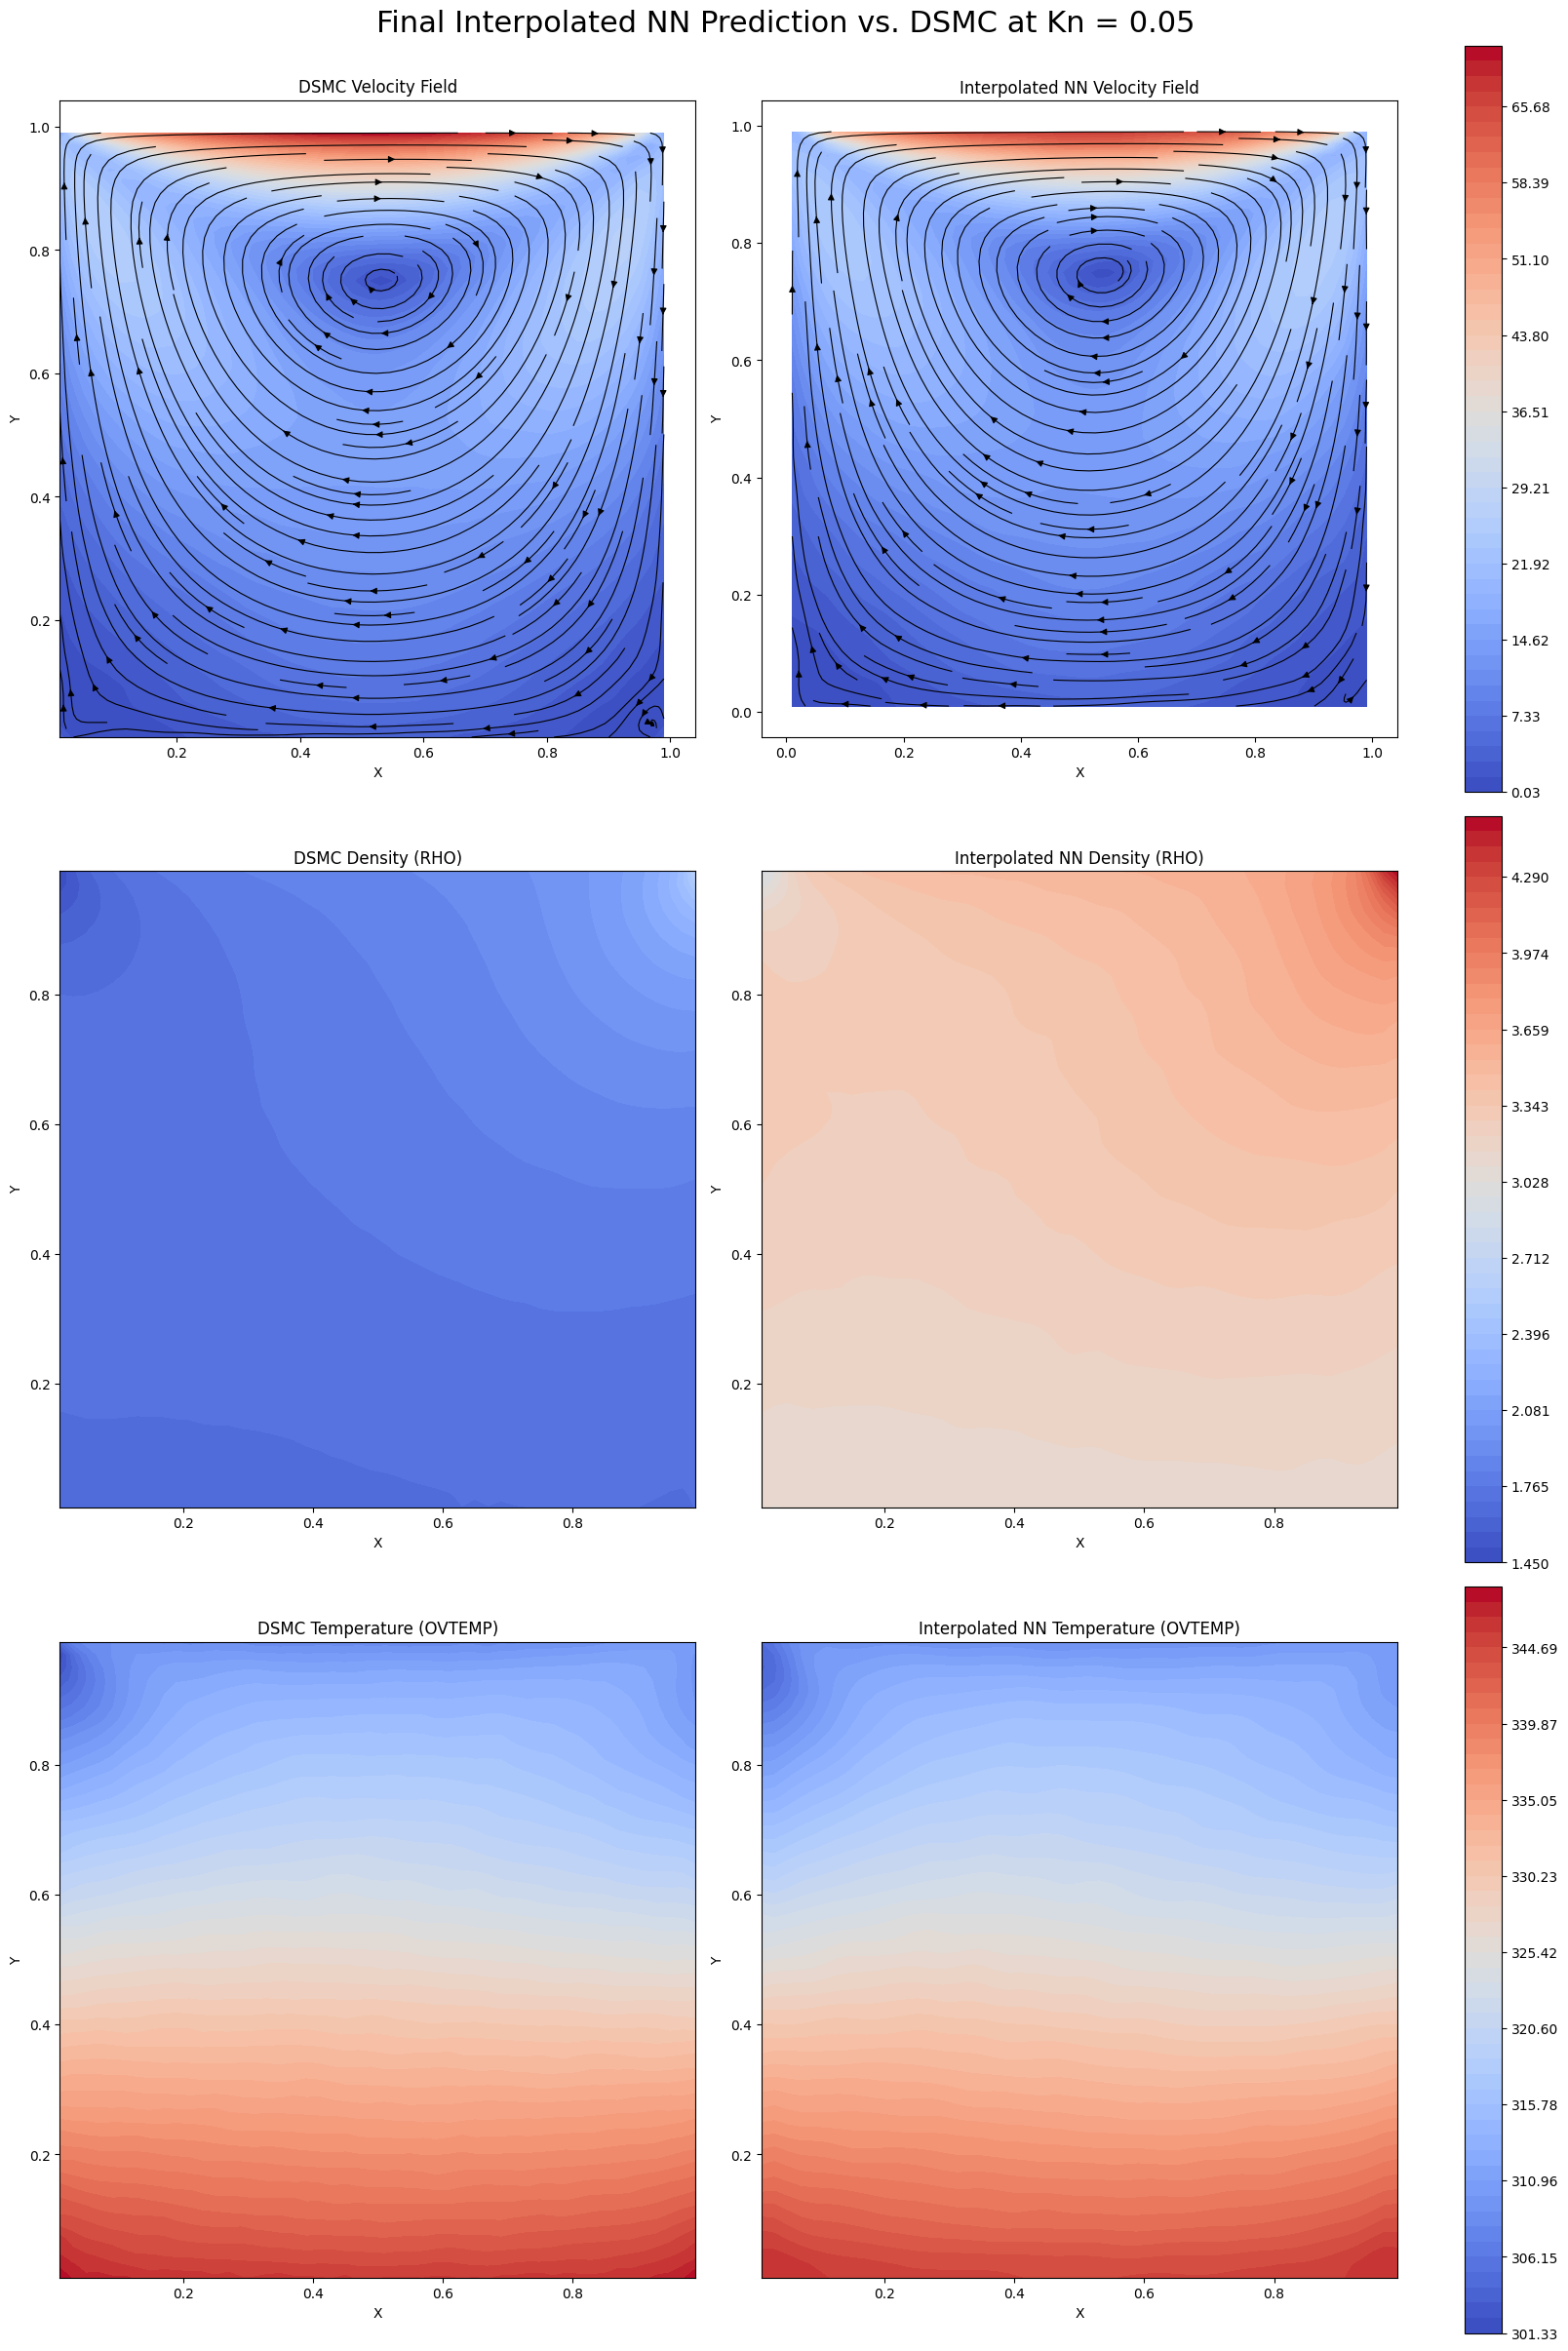

In [ ]:
# --- گام ۰: وارد کردن کتابخانه‌ها و تنظیمات اولیه ---
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import random

# برای اطمینان از نتایج تکرارپذیر
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# --- گام ۱: تابع پارسر نهایی برای خواندن فایل‌های Tecplot ---
def parse_tecplot_block_ascii(file_path):
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f: content = f.read()
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match: raise ValueError("Could not find VARIABLES block.")
        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)
        if not variables: raise ValueError("No variables found.")
        num_vars = len(variables)
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match: raise ValueError("Could not find I, J dimensions.")
        i_dim, j_dim = int(zone_header_match.group(2)), int(zone_header_match.group(4))
        num_points = i_dim * j_dim
        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match: raise ValueError("Could not find DT line.")
        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]
        flat_data = np.fromstring(data_str, sep=' ')
        expected_size = num_vars * num_points
        if flat_data.size < expected_size: raise ValueError(f"Data size mismatch: Expected {expected_size}, Found {flat_data.size}")
        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)
        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata
    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

# --- گام ۲: تعریف معماری موفق و داده‌ها ---
def create_proven_specialist_model(input_shape, output_shape):
    class FourierFeatures(layers.Layer):
        def __init__(self, output_dims, scale=2.5):
            super(FourierFeatures, self).__init__()
            self.output_dims, self.scale = output_dims, scale
            self.B = self.add_weight(name='B', shape=[2, self.output_dims // 2], initializer=tf.random_normal_initializer(stddev=self.scale), trainable=False)
        def call(self, x):
            x_proj = 2 * np.pi * x @ self.B
            return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)
    L2_LAMBDA, FF_DIMS, DENSE_UNITS = 1e-6, 256, 256
    pos_input = keras.Input(shape=input_shape, name='position_input')
    ff_layer = FourierFeatures(FF_DIMS)(pos_input)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(ff_layer)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(DENSE_UNITS, activation="swish", kernel_regularizer=l2(L2_LAMBDA))(x)
    output_layer = layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(inputs=pos_input, outputs=output_layer)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error")
    return model

file_kn_map = {
    'CavityKn10': 10.0, 'CavityKn1': 1.0, 'CavityKn05': 0.5, 'CavityKn01': 0.1,
    'CavityKn005': 0.05, 'CavityKn001': 0.01, 'CavityKn0001': 0.001
}
test_kn_value = 0.05
DATA_DIR = './'

# --- گام ۳: آموزش خانواده مدل‌ها (با حلقه آموزش کاملاً اصلاح‌شده) ---
trained_models = {}
train_kn_values = sorted([kn for kn in file_kn_map.values() if kn != test_kn_value])

for kn_val in train_kn_values:
    start_time = time.time()
    print(f"\n{'='*50}\nTraining specialist model for Kn = {kn_val}\n{'='*50}")

    basename = [name for name, kn in file_kn_map.items() if kn == kn_val][0]
    possible_paths = [os.path.join(DATA_DIR, basename), os.path.join(DATA_DIR, f"{basename}.dat"), os.path.join(DATA_DIR, f"{basename}.txt")]
    filepath = next((path for path in possible_paths if os.path.exists(path)), None)
    if filepath is None:
        print(f"File not found for Kn={kn_val}, skipping.")
        continue

    df, metadata = parse_tecplot_block_ascii(filepath)
    if df.empty: continue

    input_features = ['X', 'Y']
    output_features = [v for v in metadata['variables'] if v not in ['X', 'Y']]
    X_data = df[input_features].values
    y_data = df[output_features].values

    # *** CRITICAL FIX: Manually and correctly split the data ***
    # This shuffles the data and creates a proper validation set.
    X_train_loop, X_val_loop, y_train_loop, y_val_loop = train_test_split(
        X_data, y_data, test_size=0.15, random_state=42
    )

    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_loop_scaled = scaler_X.fit_transform(X_train_loop)
    y_train_loop_scaled = scaler_y.fit_transform(y_train_loop)

    X_val_loop_scaled = scaler_X.transform(X_val_loop)
    y_val_loop_scaled = scaler_y.transform(y_val_loop)

    model = create_proven_specialist_model(input_shape=(2,), output_shape=len(output_features))

    print("Starting proper training with correct validation data...")
    # The `fit` call now receives a proper, shuffled validation set.
    history = model.fit(
        X_train_loop_scaled, y_train_loop_scaled,
        epochs=1000,
        batch_size=256,
        verbose=1,
        validation_data=(X_val_loop_scaled, y_val_loop_scaled),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30)
        ]
    )

    trained_models[kn_val] = (model, scaler_X, scaler_y, metadata)
    print(f"Finished proper training for Kn = {kn_val} in {time.time() - start_time:.2f} seconds.")

# --- گام ۴: درون‌یابی (با روش خطی ساده و پایدار) ---
print(f"\n{'='*50}\nPerforming interpolation for test case Kn = {test_kn_value}\n{'='*50}")

# (کد این بخش بدون تغییر است، زیرا منطق آن درست بود)
test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]
possible_paths = [os.path.join(DATA_DIR, test_basename), os.path.join(DATA_DIR, f"{test_basename}.dat"), os.path.join(DATA_DIR, f"{test_basename}.txt")]
test_filepath = next((path for path in possible_paths if os.path.exists(path)), None)
if test_filepath is None: raise FileNotFoundError(f"Test file for Kn={test_kn_value} not found.")

test_df, test_metadata = parse_tecplot_block_ascii(test_filepath)
X_test_coords = test_df[['X', 'Y']].values
I, J = test_metadata['I'], test_metadata['J']

kn_upper = min([kn for kn in train_kn_values if kn > test_kn_value])
kn_lower = max([kn for kn in train_kn_values if kn < test_kn_value])
print(f"Found neighbors for interpolation: Kn_lower={kn_lower}, Kn_upper={kn_upper}")

model_lower, scaler_X_lower, scaler_y_lower, _ = trained_models[kn_lower]
model_upper, scaler_X_upper, scaler_y_upper, _ = trained_models[kn_upper]

X_test_lower_scaled = scaler_X_lower.transform(X_test_coords)
y_pred_lower_scaled = model_lower.predict(X_test_lower_scaled)
y_pred_lower = scaler_y_lower.inverse_transform(y_pred_lower_scaled)

X_test_upper_scaled = scaler_X_upper.transform(X_test_coords)
y_pred_upper_scaled = model_upper.predict(X_test_upper_scaled)
y_pred_upper = scaler_y_upper.inverse_transform(y_pred_upper_scaled)

log_kn_test, log_kn_lower, log_kn_upper = np.log10(test_kn_value), np.log10(kn_lower), np.log10(kn_upper)
weight = (log_kn_test - log_kn_lower) / (log_kn_upper - log_kn_lower)
print(f"Interpolation weight (w) = {weight:.4f}")

y_pred_final = (1 - weight) * y_pred_lower + weight * y_pred_upper
y_pred_df = pd.DataFrame(y_pred_final, columns=output_features)
y_pred_df['X'], y_pred_df['Y'] = test_df['X'].values, test_df['Y'].values

# --- گام ۵: مصورسازی جامع نتایج ---
# (کد این بخش بدون تغییر است)
def plot_full_field_comparison(ground_truth_df, df_pred, I, J, kn_value):
    fig, axes = plt.subplots(3, 2, figsize=(16, 24), constrained_layout=True)
    fig.suptitle(f'Final Interpolated NN Prediction vs. DSMC at Kn = {kn_value}', fontsize=22)
    X_grid, Y_grid = ground_truth_df['X'].values.reshape(J, I), ground_truth_df['Y'].values.reshape(J, I)

    # Velocity
    Vmag_true, U_true_grid, V_true_grid = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2).values.reshape(J, I), ground_truth_df['U'].values.reshape(J, I), ground_truth_df['V'].values.reshape(J, I)
    Vmag_pred, U_pred_grid, V_pred_grid = np.sqrt(df_pred['U']**2 + df_pred['V']**2).values.reshape(J, I), df_pred['U'].values.reshape(J, I), df_pred['V'].values.reshape(J, I)
    vmin, vmax = np.min([Vmag_true, Vmag_pred]), np.max([Vmag_true, Vmag_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[0, 0].set_title('DSMC Velocity Field'); axes[0, 0].contourf(X_grid, Y_grid, Vmag_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); axes[0, 0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='black', linewidth=0.8)
    axes[0, 1].set_title('Interpolated NN Velocity Field'); cf_v = axes[0, 1].contourf(X_grid, Y_grid, Vmag_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); axes[0, 1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='black', linewidth=0.8); fig.colorbar(cf_v, ax=axes[0, :].ravel().tolist())

    # Density
    Rho_true, Rho_pred = ground_truth_df['RHO'].values.reshape(J, I), df_pred['RHO'].values.reshape(J, I)
    vmin, vmax = np.min([Rho_true, Rho_pred]), np.max([Rho_true, Rho_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[1, 0].set_title('DSMC Density (RHO)'); axes[1, 0].contourf(X_grid, Y_grid, Rho_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1, 1].set_title('Interpolated NN Density (RHO)'); cf_r = axes[1, 1].contourf(X_grid, Y_grid, Rho_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); fig.colorbar(cf_r, ax=axes[1, :].ravel().tolist())

    # Temperature
    Temp_true, Temp_pred = ground_truth_df['OVTEMP'].values.reshape(J, I), df_pred['OVTEMP'].values.reshape(J, I)
    vmin, vmax = np.min([Temp_true, Temp_pred]), np.max([Temp_true, Temp_pred]); levels = np.linspace(vmin, vmax, 50)
    axes[2, 0].set_title('DSMC Temperature (OVTEMP)'); axes[2, 0].contourf(X_grid, Y_grid, Temp_true, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[2, 1].set_title('Interpolated NN Temperature (OVTEMP)'); cf_t = axes[2, 1].contourf(X_grid, Y_grid, Temp_pred, levels=levels, cmap='coolwarm', vmin=vmin, vmax=vmax); fig.colorbar(cf_t, ax=axes[2, :].ravel().tolist())

    for ax in axes.flat: ax.set_aspect('equal', adjustable='box'); ax.set_xlabel('X'); ax.set_ylabel('Y')
    output_filename = f'interpolated_results_kn_{kn_value}.jpg'; plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nنمودار جامع در فایل '{output_filename}' ذخیره شد."); plt.show()

plot_full_field_comparison(test_df, y_pred_df, I, J, test_kn_value)